In [25]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from scipy import stats
import json
import os
import warnings

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Constants - matched with hyperparameter tuning
RANDOM_STATE = 42
CV_SPLITS = 10  # Consistent with hyperparameter tuning

# Create results directory
RESULTS_DIR = 'results/LDA_Product_Classification_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Filter warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="Stochastic Optimizer")

In [26]:
# Data Preparation and Model Loading Functions
def prepare_data():
    """Load and prepare data with one-hot encoded storage condition"""
    print("Loading data and preparing features...")
    data = pd.read_csv('augmented_bakery_data.csv')
    
    # Encode Product_Type
    le_product = LabelEncoder()
    data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
    
    # One-hot encode Storage_Condition
    storage_onehot = pd.get_dummies(data['Storage_Condition'], prefix='Storage')
    
    # Prepare spectral features
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X_base = data[feature_cols]
    
    # Scale spectral features
    scaler = StandardScaler()
    X_base_scaled = scaler.fit_transform(X_base)
    
    # Combine scaled features with one-hot storage condition
    X_with_storage = np.hstack([X_base_scaled, storage_onehot.values])
    X_without_storage = X_base_scaled
    y_product = data['Product_Type_encoded'].values
    
    print(f"\nDataset shapes:")
    print(f"X without storage condition: {X_without_storage.shape}")
    print(f"X with storage condition: {X_with_storage.shape}")
    print(f"Product types: {dict(zip(le_product.classes_, range(len(le_product.classes_))))}")
    
    return X_with_storage, X_without_storage, y_product, le_product.classes_, feature_cols
def load_best_parameters():
    """Load best parameters from JSON file"""
    try:
        with open('hyperparameter_tuning/LDA_product_type_results.json', 'r') as f:
        #with open('hyperparameter_tuning/grid_search_lda_product_type_results.json', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print("Error: Could not find hyperparameter tuning results file.")
        print("Please run hyperparameter tuning first.")
        return None

def create_models(best_params, scenario='with_storage_condition'):
    """Create models with best parameters"""
    models = {}
    params = best_params[scenario]
    
    for model_name, model_params in params.items():
        if model_name == 'SVM':
            models[model_name] = SVC(**model_params, random_state=RANDOM_STATE, probability=True)
        elif model_name == 'Random Forest':
            models[model_name] = RandomForestClassifier(**model_params, random_state=RANDOM_STATE)
        elif model_name == 'KNN':
            models[model_name] = KNeighborsClassifier(**model_params)
        elif model_name == 'Neural Network':
            models[model_name] = MLPClassifier(**model_params, random_state=RANDOM_STATE)
        elif model_name == 'Logistic Regression':
            models[model_name] = LogisticRegression(**model_params, random_state=RANDOM_STATE)
    
    return models

## LDA Analysis Functions

These functions implement Linear Discriminant Analysis (LDA) for both dimensionality reduction and classification:
1. `visualize_lda_projections`: Creates scatter plots showing sample projections in LDA space
2. `analyze_lda_coefficients`: Analyzes which features contribute most to the discriminant functions
3. `evaluate_models_with_lda`: Evaluates LDA as a standalone classifier and as preprocessing for other models

These visualizations and analyses help understand the discriminative power of spectral features.

In [27]:
# LDA Analysis Functions
def visualize_lda_projections(X, y, class_labels, title_suffix=""):
    """Visualize LDA projections of the data"""
    # Fit LDA on the full dataset
    lda = LDA(n_components=min(2, len(np.unique(y))-1))  # Use 2 components for visualization (or fewer if needed)
    X_lda = lda.fit_transform(X, y)
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'LDA1': X_lda[:, 0],
        'class': [class_labels[i] for i in y]
    })
    
    # Add LDA2 if available (only if we have more than 2 classes)
    if X_lda.shape[1] > 1:
        df['LDA2'] = X_lda[:, 1]
    else:
        # If only one LDA component, add a zero column for plotting
        df['LDA2'] = np.zeros(X_lda.shape[0])
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='LDA1', y='LDA2', hue='class', data=df, palette='viridis', s=100, alpha=0.7)
    plt.title(f'LDA Projection of Product Types {title_suffix}')
    plt.xlabel('First Discriminant')
    plt.ylabel('Second Discriminant' if X_lda.shape[1] > 1 else 'No Second Discriminant')
    plt.grid(alpha=0.3)
    plt.legend(title='Product Type')
    
    plt.tight_layout()
    filename = f'lda_projection{"_" + title_suffix.lower().replace(" ", "_") if title_suffix else ""}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()
    
    # Return the LDA model and transformed data
    return lda, X_lda

def analyze_lda_coefficients(lda, feature_names, title_suffix):
    """Analyze and visualize LDA coefficients"""
    # Get coefficients
    try:
        coefficients = lda.coef_
        print(f"Coefficients shape: {coefficients.shape}")
        print(f"Number of feature names: {len(feature_names)}")
        
        # Check if we need to transpose the coefficients
        if coefficients.shape[0] != len(feature_names) and coefficients.shape[1] == len(feature_names):
            # If columns match features instead of rows, transpose
            coefficients = coefficients.T
            print(f"Transposed coefficients shape: {coefficients.shape}")
        elif coefficients.shape == (1, len(feature_names)):
            # If we have only one class (binary classification)
            coefficients = coefficients.T
            print(f"Binary classification case, transposed shape: {coefficients.shape}")
        
        # If we still don't match, create something that will work
        if len(feature_names) != coefficients.shape[0]:
            print("WARNING: Shape mismatch after adjustments. Creating simplified visualization.")
            # Create a simplified version with just one feature
            simplified_coef = coefficients.mean(axis=0) if coefficients.shape[0] == 1 else coefficients[:, 0]
            
            # Create a Series for better visualization
            coef_series = pd.Series(simplified_coef, index=feature_names)
            
            # Plot the top coefficients by absolute value
            plt.figure(figsize=(12, 8))
            top_n = min(20, len(feature_names))
            coef_series.abs().nlargest(top_n).sort_values().plot(kind='barh')
            
            plt.title(f'LDA Top Coefficients {title_suffix}')
            plt.xlabel('Coefficient Value')
            plt.tight_layout()
            
            # Save plot
            filename = f'lda_top_coefficients_{title_suffix.lower().replace(" ", "_")}.png'
            plt.savefig(os.path.join(RESULTS_DIR, filename))
            plt.close()
            
            return coef_series
            
        # Create a regular DataFrame if shapes match now
        coef_df = pd.DataFrame(
            coefficients,
            index=feature_names,
            columns=[f'Discriminant {i+1}' for i in range(coefficients.shape[1])]
        )
        
        # If too many features, just show top ones
        if len(feature_names) > 15:
            # Get top features based on absolute mean across discriminants
            top_features = coef_df.abs().mean(axis=1).nlargest(15).index
            coef_df = coef_df.loc[top_features]
        
        # Plotting
        plt.figure(figsize=(10, 8))
        sns.heatmap(coef_df, cmap='RdBu', center=0, annot=True, fmt='.2f')
        plt.title(f'LDA Coefficients {title_suffix}')
        plt.tight_layout()
        
        # Save plot
        filename = f'lda_coefficients_{title_suffix.lower().replace(" ", "_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.close()
        
        return coef_df
        
    except AttributeError as e:
        print(f"Warning: LDA model doesn't have coefficients attribute. Error: {e}")
        
        # Try to access attributes that might be available
        if hasattr(lda, 'scalings_'):
            print("Using scalings_ attribute instead")
            scalings = lda.scalings_
            
            # Create a simplified visualization
            plt.figure(figsize=(12, 8))
            
            # Take first component if multi-dimensional
            if scalings.ndim > 1:
                display_data = scalings[:, 0]
            else:
                display_data = scalings
                
            # Plot top coefficients
            if len(feature_names) == len(display_data):
                s = pd.Series(display_data, index=feature_names)
                s.abs().nlargest(15).sort_values().plot(kind='barh')
                
                plt.title(f'LDA Feature Importance {title_suffix}')
                plt.tight_layout()
                
                # Save plot
                filename = f'lda_importance_{title_suffix.lower().replace(" ", "_")}.png'
                plt.savefig(os.path.join(RESULTS_DIR, filename))
                plt.close()
                
                return s
        
        return None    
    
    """Analyze and visualize LDA coefficients"""
    # Get coefficients
    try:
        coefficients = lda.coef_.T  # Transpose the coefficients to match feature count
    except AttributeError:
        print(f"Warning: LDA model doesn't have coefficients attribute")
        return None
    
    print(f"Coefficients shape: {coefficients.shape}")
    print(f"Number of feature names: {len(feature_names)}")
    
    # Create a DataFrame for the coefficients
    coef_df = pd.DataFrame(
        coefficients, 
        columns=feature_names,  # Use columns instead of index for feature names
    )
    
    # If too many features, just show top 15 by absolute value
    if len(feature_names) > 15:
        top_features = coef_df.abs().mean().nlargest(15).index
        coef_df = coef_df[top_features]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(coef_df.T, cmap='RdBu', center=0, annot=True, fmt='.2f')
    plt.title(f'LDA Coefficients {title_suffix}')
    plt.tight_layout()
    
    # Save plot
    filename = f'lda_coefficients_{title_suffix.lower().replace(" ", "_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.close()
    
    return coef_df
    
    """Analyze and visualize LDA coefficients"""
    # Get coefficients
    try:
        coefficients = lda.coef_
    except AttributeError:
        print(f"Warning: LDA model doesn't have coefficients attribute")
        return None
    
    # Debug print to check shapes
    print(f"Coefficients shape: {coefficients.shape}")
    print(f"Number of feature names: {len(feature_names)}")
    
    # Ensure feature_names matches the number of coefficients
    if len(feature_names) != coefficients.shape[0]:
        print(f"Warning: Number of feature names ({len(feature_names)}) doesn't match "
              f"number of coefficients ({coefficients.shape[0]})")
        # Either truncate or extend feature_names to match
        if len(feature_names) < coefficients.shape[0]:
            # Add generic names for extra features
            extra_features = [f'Unknown_Feature_{i}' for i in range(len(feature_names), coefficients.shape[0])]
            feature_names = list(feature_names) + extra_features
        else:
            # Truncate feature names to match coefficients
            feature_names = feature_names[:coefficients.shape[0]]
    
    # Create a DataFrame for the coefficients
    coef_df = pd.DataFrame(
        coefficients, 
        index=feature_names,
        columns=[f'LD{i+1}' for i in range(coefficients.shape[1])]
    )
    
    # If too many features, just show top 15 by absolute value for the first discriminant
    if len(feature_names) > 15:
        top_features = coef_df.iloc[:, 0].abs().nlargest(15).index
        coef_df = coef_df.loc[top_features]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(coef_df, cmap='RdBu', center=0, annot=True, fmt='.2f')
    plt.title(f'LDA Coefficients {title_suffix}')
    plt.tight_layout()
    
    # Save plot
    filename = f'lda_coefficients_{title_suffix.lower().replace(" ", "_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.close()
    
    return coef_df
def evaluate_models_with_lda(X, y, models, cv=CV_SPLITS):
    """Evaluate models using cross-validation with LDA"""
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    num_classes = len(np.unique(y))  # Number of unique classes in the target variable
    
    # First evaluate LDA as a standalone classifier
    print("\nEvaluating LDA as a standalone classifier...")
    lda_classifier = LDA(n_components=num_classes-1)
    lda_cv_scores = cross_val_score(lda_classifier, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    lda_y_pred = cross_val_predict(lda_classifier, X, y, cv=skf, n_jobs=-1)
    
    # Store LDA results
    results['LDA'] = {
        'fold_accuracies': lda_cv_scores,
        'mean_accuracy': lda_cv_scores.mean(),
        'std_accuracy': lda_cv_scores.std(),
        'confusion_matrix': confusion_matrix(y, lda_y_pred),
        'classification_report': classification_report(y, lda_y_pred)
    }
    
    print(f"LDA Classifier Final Results:")
    print(f"Mean accuracy: {results['LDA']['mean_accuracy']:.4f} ± {results['LDA']['std_accuracy']:.4f}")
    print("\nClassification Report:")
    print(results['LDA']['classification_report'])
    
    # Then evaluate other models with LDA preprocessing
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} with LDA preprocessing...")
        
        pipeline = Pipeline([
            ('lda', LDA(n_components=num_classes - 1)),
            (model_name, model)
        ])
        
        cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
        y_pred = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)
        
        results[f"{model_name}+LDA"] = {
            'fold_accuracies': cv_scores,
            'mean_accuracy': cv_scores.mean(),
            'std_accuracy': cv_scores.std(),
            'confusion_matrix': confusion_matrix(y, y_pred),
            'classification_report': classification_report(y, y_pred),
            'model': model,  # Store the model for learning curves
            'pipeline': pipeline  # Store the pipeline for learning curves
        }
        
        print(f"{model_name}+LDA Final Results:")
        print(f"Mean accuracy: {results[f'{model_name}+LDA']['mean_accuracy']:.4f} ± {results[f'{model_name}+LDA']['std_accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[f"{model_name}+LDA"]['classification_report'])
    
    return results

# Visualization Functions

In [28]:
# Visualization Functions
def plot_model_comparison(results_without, results_with):
    """Plot model comparison bar chart"""
    # Get models that are in both results
    models = sorted(set(results_without.keys()) & set(results_with.keys()))
    
    means_without = [results_without[model]['mean_accuracy'] for model in models]
    stds_without = [results_without[model]['std_accuracy'] for model in models]
    
    means_with = [results_with[model]['mean_accuracy'] for model in models]
    stds_with = [results_with[model]['std_accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, means_without, width, yerr=stds_without,
                    label='Without Storage Condition', capsize=5)
    rects2 = ax.bar(x + width/2, means_with, width, yerr=stds_with,
                    label='With Storage Condition', capsize=5)
    
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Model Comparison for Product Type Classification with LDA')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'lda_product_type_comparison.png'))
    plt.show()

def plot_confusion_matrices(results_without, results_with, class_labels):
    """Plot confusion matrices side by side for with/without storage condition"""
    # Get models that are in both results
    models = sorted(set(results_without.keys()) & set(results_with.keys()))
    
    for model_name in models:
        # Create two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot first confusion matrix (Without Storage Condition)
        sns.heatmap(results_without[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels, ax=ax1)
        ax1.set_title(f'{model_name} - Without Storage Condition')
        ax1.set_ylabel('Actual')
        ax1.set_xlabel('Predicted')
        
        # Plot second confusion matrix (With Storage Condition)
        sns.heatmap(results_with[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels, ax=ax2)
        ax2.set_title(f'{model_name} - With Storage Condition')
        ax2.set_ylabel('Actual')
        ax2.set_xlabel('Predicted')
        
        plt.tight_layout()
        filename = f'confusion_matrix_{model_name.lower().replace(" ", "_").replace("+", "_with_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.close()

def plot_learning_curves_pipeline(X, y, result_item, model_name, cv=CV_SPLITS):
    """Plot learning curves with confidence intervals for a pipeline"""
    # Use the pipeline stored in the results
    pipeline = result_item.get('pipeline')
    if pipeline is None:
        print(f"No pipeline found for {model_name}")
        return None
    
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y,
        train_sizes=train_sizes,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation Score', color='red', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='red')
    
    plt.title(f'Learning Curves - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    final_train = f"Final training score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}"
    final_val = f"Final validation score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}"
    plt.annotate(final_train, xy=(0.6, 0.2), xycoords='axes fraction')
    plt.annotate(final_val, xy=(0.6, 0.15), xycoords='axes fraction')
    
    plt.tight_layout()
    filename = f'learning_curve_{model_name.lower().replace(" ", "_").replace("+", "_with_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.close()
    
    return {
        'train_sizes': train_sizes,
        'train_scores': {'mean': train_mean, 'std': train_std},
        'val_scores': {'mean': val_mean, 'std': val_std}
    }

def perform_statistical_analysis(results_without, results_with):
    """Perform statistical analysis"""
    analysis_results = []
    
    print("\nStatistical Analysis Results:")
    print("=" * 50)
    
    # Get models that are in both results
    models = sorted(set(results_without.keys()) & set(results_with.keys()))
    
    for model in models:
        acc_without = results_without[model]['fold_accuracies']
        acc_with = results_with[model]['fold_accuracies']
        
        t_stat, p_value = stats.ttest_rel(acc_with, acc_without)
        improvement = (np.mean(acc_with) - np.mean(acc_without)) * 100
        
        result = {
            'Model': model,
            'Accuracy without Storage Condition': f"{np.mean(acc_without):.4f} ± {np.std(acc_without):.4f}",
            'Accuracy with Storage Condition': f"{np.mean(acc_with):.4f} ± {np.std(acc_with):.4f}",
            'Improvement (%)': f"{improvement:.2f}%",
            'p-value': f"{p_value:.4f}",
            'Significant': "Yes" if p_value < 0.05 else "No"
        }
        analysis_results.append(result)
        
        print(f"\n{model}:")
        print(f"- Without Storage Condition: {result['Accuracy without Storage Condition']}")
        print(f"- With Storage Condition: {result['Accuracy with Storage Condition']}")
        print(f"- Improvement: {improvement:.2f}%")
        print(f"- Statistical Significance (p < 0.05): {result['Significant']} (p = {p_value:.4f})")

    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv(os.path.join(RESULTS_DIR, 'lda_product_type_statistical_analysis.csv'), index=False)
    return results_df

In [29]:
# Summary Analysis Functions
def save_analysis_summary(results_without, results_with, stats_results):
    """Generate and save comprehensive analysis summary"""
    
    with open(os.path.join(RESULTS_DIR, 'lda_product_type_analysis_summary.txt'), 'w') as f:
        # Header
        f.write("LDA Product Type Classification Analysis Summary\n")
        f.write("==================================================\n\n")
        
        # 1. LDA Performance section
        f.write("1. LDA Performance as a Classifier:\n\n")
        
        if 'LDA' in results_without and 'LDA' in results_with:
            lda_without = results_without['LDA']
            lda_with = results_with['LDA']
            
            f.write("LDA Without Storage Condition:\n")
            f.write(f"- Accuracy: {lda_without['mean_accuracy']:.4f} ± {lda_without['std_accuracy']:.4f}\n\n")
            
            f.write("LDA With Storage Condition:\n")
            f.write(f"- Accuracy: {lda_with['mean_accuracy']:.4f} ± {lda_with['std_accuracy']:.4f}\n\n")
            
            # Calculate improvement
            improvement = ((lda_with['mean_accuracy'] - lda_without['mean_accuracy']) / 
                          lda_without['mean_accuracy']) * 100
            
            f.write(f"LDA Improvement with Storage Condition: {improvement:.2f}%\n\n")
        
        # 2. Best Performing Models section
        f.write("2. Best Performing Models:\n\n")
        
        # Find best models
        best_without = max(results_without.items(), 
                         key=lambda x: x[1]['mean_accuracy'])
        best_with = max(results_with.items(), 
                       key=lambda x: x[1]['mean_accuracy'])
        
        # Without Storage Condition 
        f.write("Without Storage Condition:\n")
        f.write(f"- Best Model: {best_without[0]}\n")
        f.write(f"- Accuracy: {best_without[1]['mean_accuracy']:.4f} ± "
                f"{best_without[1]['std_accuracy']:.4f}\n\n")
        
        # With Storage Condition
        f.write("With Storage Condition:\n")
        f.write(f"- Best Model: {best_with[0]}\n")
        f.write(f"- Accuracy: {best_with[1]['mean_accuracy']:.4f} ± "
                f"{best_with[1]['std_accuracy']:.4f}\n\n")
        
        # 3. Impact of Storage Condition section
        f.write("3. Impact of Storage Condition with LDA:\n")
        
        # Create DataFrame for formatted table
        data = []
        # Get models that are in both results and in stats_results
        models = sorted(set(results_without.keys()) & set(results_with.keys()))
        
        for model_name in models:
            if model_name not in stats_results['Model'].values:
                continue
                
            acc_without = results_without[model_name]['mean_accuracy']
            std_without = results_without[model_name]['std_accuracy']
            
            acc_with = results_with[model_name]['mean_accuracy']
            std_with = results_with[model_name]['std_accuracy']
            
            improvement = ((acc_with - acc_without) / acc_without) * 100
            
            # Get p-value from stats_results DataFrame
            p_value = float(stats_results[stats_results['Model'] == model_name]['p-value'].values[0])
            
            data.append({
                'Model': model_name,
                'Accuracy without Storage': f"{acc_without:.4f} ± {std_without:.4f}",
                'Accuracy with Storage': f"{acc_with:.4f} ± {std_with:.4f}",
                'Improvement (%)': f"{improvement:.2f}%",
                'p-value': f"{p_value:.4f}",
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        
        # Convert to DataFrame and write as formatted table
        if data:
            df = pd.DataFrame(data)
            f.write(df.to_string(index=False))
        else:
            f.write("No models available for statistical comparison.\n")
        
        # 4. Additional Insights
        f.write("\n\n4. Additional Insights:\n")
        f.write("-----------------------\n")
        
        # Count models with significant improvement
        significant_improvements = sum(1 for d in data if float(d['Improvement (%)'].strip('%')) > 0 
                                    and d['Significant'] == 'Yes')
        f.write(f"\nNumber of models with significant improvement: {significant_improvements}\n")
        
        # Best improvement
        if data:
            best_improvement = max(data, key=lambda x: float(x['Improvement (%)'].strip('%')))
            f.write(f"Model with best improvement: {best_improvement['Model']} "
                    f"({best_improvement['Improvement (%)']}) "
                    f"(Significant: {best_improvement['Significant']})\n")
        
        # Overall recommendation
        f.write("\nOverall Recommendation:\n")
        if significant_improvements > 0:
            f.write("Including storage condition information appears beneficial for LDA-based product type classification.\n")
        else:
            f.write("Storage condition information does not significantly improve LDA-based product type classification.\n")
            best_model_name = best_without[0]
            f.write(f"Consider using {best_model_name} without storage condition for simplicity and generalization.\n")
        
        # 5. LDA-specific insights
        f.write("\n5. LDA-specific Insights:\n")
        f.write("-----------------------\n")
        f.write("- LDA reduces the high-dimensional spectral data to a lower-dimensional space defined by the discriminant functions.\n")
        f.write("- The first discriminant function captures the most variance between classes.\n")
        f.write("- The LDA projection visualizations show how well the classes are separated in the lower-dimensional space.\n")
        f.write("- The feature importance analysis reveals which spectral features are most discriminative for product type classification.\n")

def rank_models(results_without, results_with):
    """Rank models by performance"""
    # Combine all models from both scenarios
    all_models = []
    
    for model_name, results in results_without.items():
        all_models.append({
            'Model': f"{model_name} (without storage)",
            'Accuracy': results['mean_accuracy'],
            'Std': results['std_accuracy']
        })
    
    for model_name, results in results_with.items():
        all_models.append({
            'Model': f"{model_name} (with storage)",
            'Accuracy': results['mean_accuracy'],
            'Std': results['std_accuracy']
        })
    
    # Sort by accuracy (descending)
    ranked_models = sorted(all_models, key=lambda x: x['Accuracy'], reverse=True)
    
    # Create a DataFrame and print
    df = pd.DataFrame(ranked_models)
    df['Rank'] = range(1, len(df) + 1)
    df = df[['Rank', 'Model', 'Accuracy', 'Std']]
    
    print("\nModel Rankings by Accuracy:")
    print(df)
    
    # Save to CSV
    df.to_csv(os.path.join(RESULTS_DIR, 'model_rankings.csv'), index=False)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Plot bars
    bars = plt.bar(df['Model'], df['Accuracy'], yerr=df['Std'], capsize=5)
    
    # Color bars based on whether they have storage condition
    colors = ['#1f77b4' if '(without storage)' in model else '#ff7f0e' for model in df['Model']]
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('LDA Models Ranked by Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Without Storage'),
        Patch(facecolor='#ff7f0e', label='With Storage')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'model_rankings.png'))
    plt.close()
    
    return df

Loading data and preparing features...

Dataset shapes:
X without storage condition: (180, 202)
X with storage condition: (180, 205)
Product types: {'Bread': 0, 'Cookies': 1}
Loading best parameters and creating models...

Visualizing LDA projections...


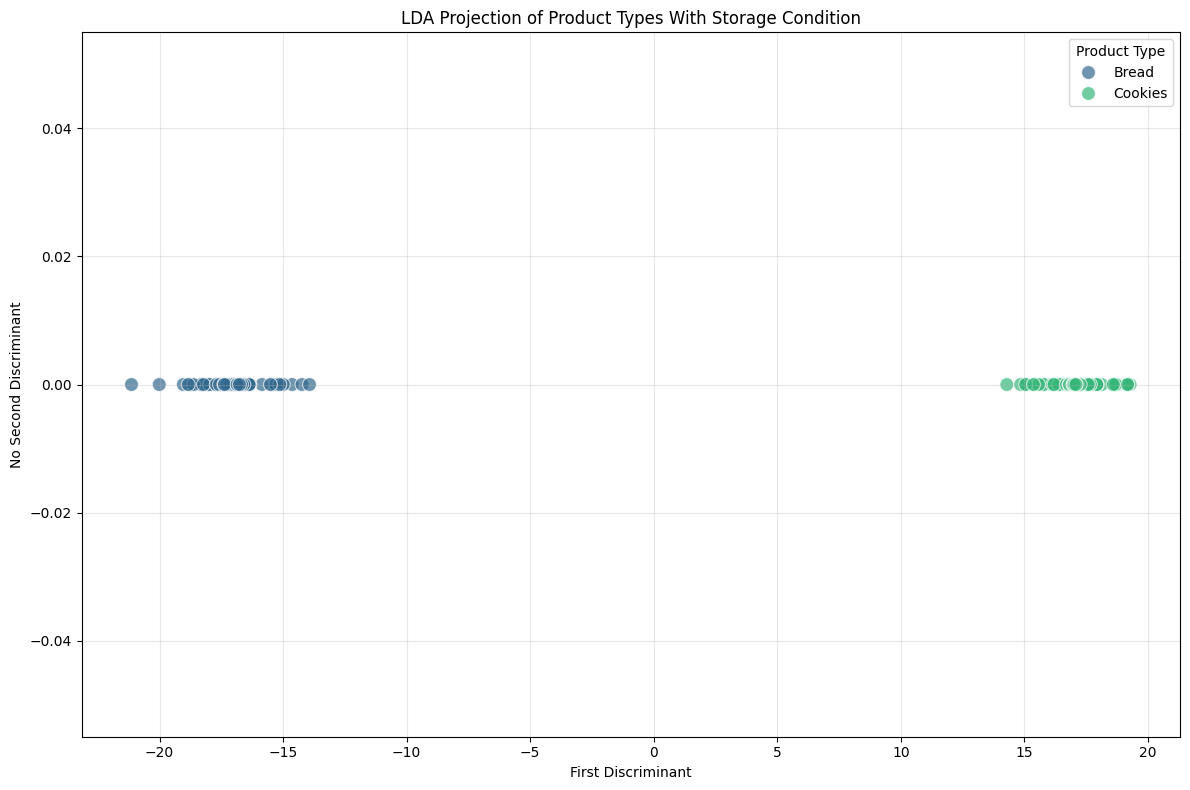

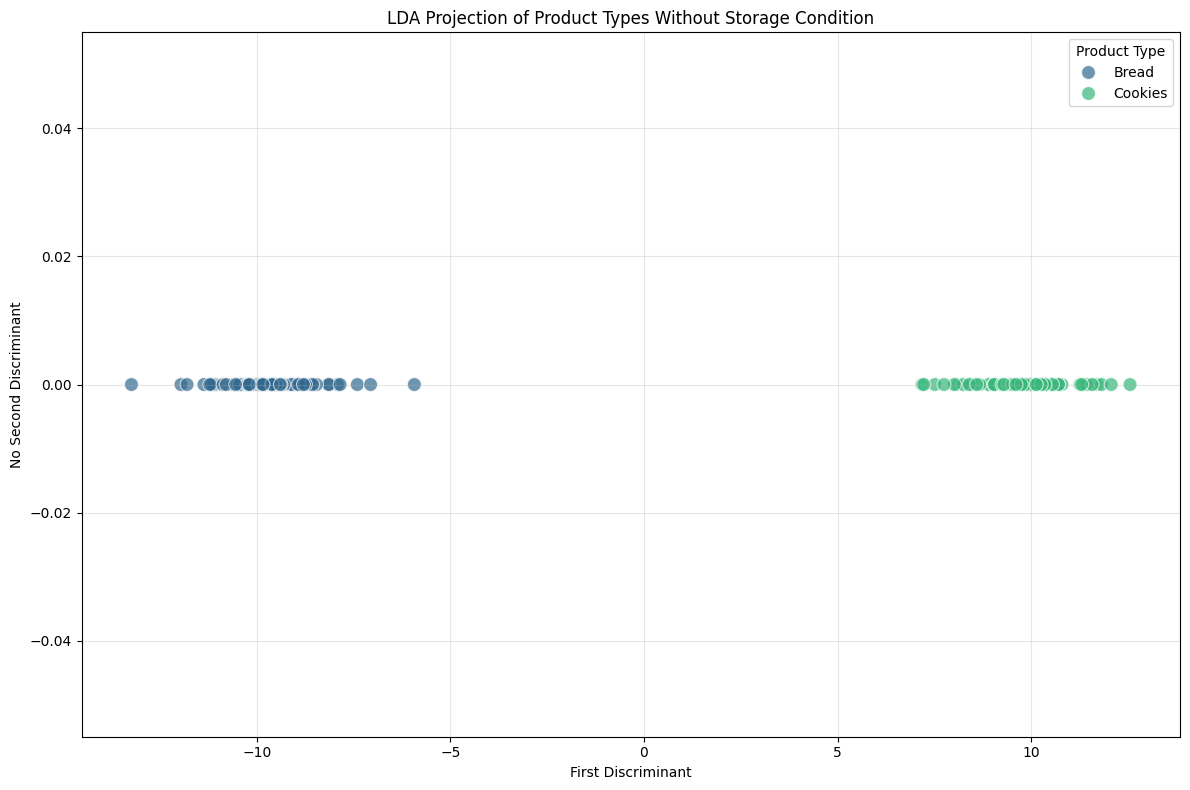


Analyzing LDA coefficients...
LDA with storage shape: (1, 205)
LDA without storage shape: (1, 202)
Shape of feature_cols: 202
Shape of all_features_with_storage: 205
Coefficients shape: (1, 205)
Number of feature names: 205
Transposed coefficients shape: (205, 1)
Coefficients shape: (1, 202)
Number of feature names: 202
Transposed coefficients shape: (202, 1)

Evaluating models with storage condition...

Evaluating LDA as a standalone classifier...
LDA Classifier Final Results:
Mean accuracy: 0.6944 ± 0.1002

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        90
           1       0.71      0.67      0.69        90

    accuracy                           0.69       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.70      0.69      0.69       180


Evaluating SVM with LDA preprocessing...
SVM+LDA Final Results:
Mean accuracy: 0.6333 ± 0.1222

Classification Report:
              

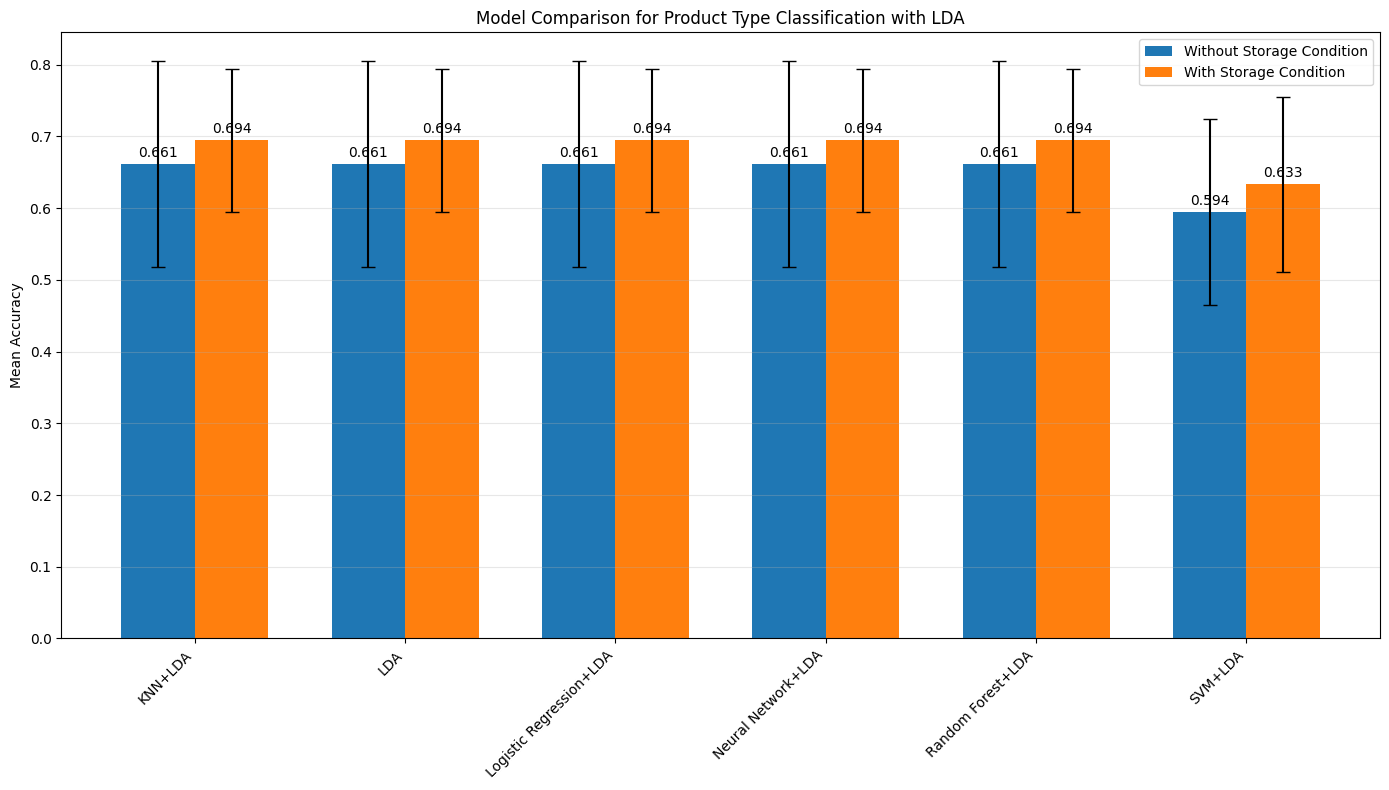


Statistical Analysis Results:

KNN+LDA:
- Without Storage Condition: 0.6611 ± 0.1437
- With Storage Condition: 0.6944 ± 0.1002
- Improvement: 3.33%
- Statistical Significance (p < 0.05): No (p = 0.5312)

LDA:
- Without Storage Condition: 0.6611 ± 0.1437
- With Storage Condition: 0.6944 ± 0.1002
- Improvement: 3.33%
- Statistical Significance (p < 0.05): No (p = 0.5312)

Logistic Regression+LDA:
- Without Storage Condition: 0.6611 ± 0.1437
- With Storage Condition: 0.6944 ± 0.1002
- Improvement: 3.33%
- Statistical Significance (p < 0.05): No (p = 0.5312)

Neural Network+LDA:
- Without Storage Condition: 0.6611 ± 0.1437
- With Storage Condition: 0.6944 ± 0.1002
- Improvement: 3.33%
- Statistical Significance (p < 0.05): No (p = 0.5312)

Random Forest+LDA:
- Without Storage Condition: 0.6611 ± 0.1437
- With Storage Condition: 0.6944 ± 0.1002
- Improvement: 3.33%
- Statistical Significance (p < 0.05): No (p = 0.5312)

SVM+LDA:
- Without Storage Condition: 0.5944 ± 0.1292
- With Storage C

In [30]:
# Main Execution
if __name__ == "__main__":
    # 1. Prepare Data
    X_with_storage, X_without_storage, y_product, class_labels, feature_cols = prepare_data()
    
    # 2. Load Models
    print("Loading best parameters and creating models...")
    best_params = load_best_parameters()
    if best_params is None:
        print("Warning: Could not load hyperparameter results. Using default parameters.")
        # Create models with default parameters
        models_with_storage = {
            'SVM': SVC(probability=True, random_state=RANDOM_STATE),
            'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
            'KNN': KNeighborsClassifier(),
            'Neural Network': MLPClassifier(max_iter=1000, random_state=RANDOM_STATE),
            'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE)
        }
        models_without_storage = models_with_storage.copy()
    else:
        # Create models with tuned parameters
        models_with_storage = create_models(best_params, 'with_storage_condition')
        models_without_storage = create_models(best_params, 'without_storage_condition')
    
    # 3. Visualize LDA projections
    print("\nVisualizing LDA projections...")
    lda_with_storage, X_lda_with = visualize_lda_projections(
        X_with_storage, y_product, class_labels, "With Storage Condition"
    )
    lda_without_storage, X_lda_without = visualize_lda_projections(
        X_without_storage, y_product, class_labels, "Without Storage Condition"
    )
    
    # When calling the function:
    print("\nAnalyzing LDA coefficients...")
    print("LDA with storage shape:", getattr(lda_with_storage, 'coef_', 'No coef_ attribute').shape 
        if hasattr(lda_with_storage, 'coef_') else "No coef_ attribute")
    print("LDA without storage shape:", getattr(lda_without_storage, 'coef_', 'No coef_ attribute').shape 
        if hasattr(lda_without_storage, 'coef_') else "No coef_ attribute")

    # For with storage condition, add the storage condition feature names
    storage_columns = ['Storage_Humid', 'Storage_Open', 'Storage_Wrapped']
    all_features_with_storage = feature_cols + storage_columns

    print("Shape of feature_cols:", len(feature_cols))
    print("Shape of all_features_with_storage:", len(all_features_with_storage))

    coef_with_storage = analyze_lda_coefficients(
        lda_with_storage, all_features_with_storage, "With Storage Condition"
    )
    coef_without_storage = analyze_lda_coefficients(
        lda_without_storage, feature_cols, "Without Storage Condition"
    )
    
    # 5. Evaluate Models
    print("\nEvaluating models with storage condition...")
    results_with_storage = evaluate_models_with_lda(X_with_storage, y_product, models_with_storage)
    
    print("\nEvaluating models without storage condition...")
    results_without_storage = evaluate_models_with_lda(X_without_storage, y_product, models_without_storage)
    
    # 6. Generate Visualizations and Analysis
    print("\nGenerating visualizations and analysis...")
    
    # Model comparison plot
    plot_model_comparison(results_without_storage, results_with_storage)
    
    # Confusion matrices with actual class labels
    plot_confusion_matrices(results_without_storage, results_with_storage, class_labels)
    
    # Statistical analysis
    stats_results = perform_statistical_analysis(results_without_storage, results_with_storage)
    
    # Save analysis summary
    save_analysis_summary(results_without_storage, results_with_storage, stats_results)
    
    # Rank models
    model_rankings = rank_models(results_without_storage, results_with_storage)

    # Learning curves
    print("\nGenerating learning curves...")
    
    # For models with storage condition
    for model_name in results_with_storage:
        if model_name != 'LDA':  # LDA doesn't have a pipeline
            print(f"Generating learning curve for {model_name} (with storage)...")
            plot_learning_curves_pipeline(
                X_with_storage, y_product, 
                results_with_storage[model_name], 
                f"{model_name}_with_storage"
            )
    
    # For models without storage condition
    for model_name in results_without_storage:
        if model_name != 'LDA':  # LDA doesn't have a pipeline
            print(f"Generating learning curve for {model_name} (without storage)...")
            plot_learning_curves_pipeline(
                X_without_storage, y_product, 
                results_without_storage[model_name], 
                f"{model_name}_without_storage"
            )
    
    print("\nAnalysis complete!")
    print(f"All results saved to: {RESULTS_DIR}")